# Single-cell RNA-seq analysis workflow for 1.3 M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

100% [....................................................................] 5652968495 / 5652968495

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc._settings.ScanpyConfig.n_jobs = 40

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

CPU times: user 1min 31s, sys: 12.1 s, total: 1min 43s
Wall time: 1min 43s


(1306127, 27998)

In [7]:
# To reduce the number of cells: 
USE_FIRST_N_CELLS = 130000
adata = adata[0:USE_FIRST_N_CELLS]
adata.shape

(130000, 27998)

## Preprocessing

In [8]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [9]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 21.6 s, sys: 6.79 s, total: 28.4 s
Wall time: 28.5 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [10]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 2.58 s, sys: 1.3 s, total: 3.89 s
Wall time: 3.89 s


In [11]:
adata.shape

(128868, 21915)

### Normalize

In [12]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 940 ms, sys: 179 ms, total: 1.12 s
Wall time: 1.12 s


In [13]:
%%time
sc.pp.log1p(adata)

CPU times: user 3.86 s, sys: 0 ns, total: 3.86 s
Wall time: 3.86 s


### Select Most Variable Genes

In [14]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].toarray().ravel()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 3.71 s, sys: 1.06 s, total: 4.77 s
Wall time: 5.89 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [15]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

CPU times: user 2.32 s, sys: 91.3 ms, total: 2.41 s
Wall time: 2.41 s


In [16]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 23.3 s, sys: 14.8 s, total: 38.2 s
Wall time: 52.2 s


### Scale

In [17]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 3.32 s, sys: 404 ms, total: 3.73 s
Wall time: 3.73 s


In [18]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 388.02111172676086


## Cluster & Visualize

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [19]:
%%time
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 3min 52s, sys: 6.99 s, total: 3min 59s
Wall time: 10.7 s


### TSNE + K-means

In [20]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, use_fast_tsne=True)

CPU times: user 3h 16min 1s, sys: 49min 24s, total: 4h 5min 26s
Wall time: 13min 33s


In [21]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 9min 4s, sys: 4min 56s, total: 14min 1s
Wall time: 27.2 s


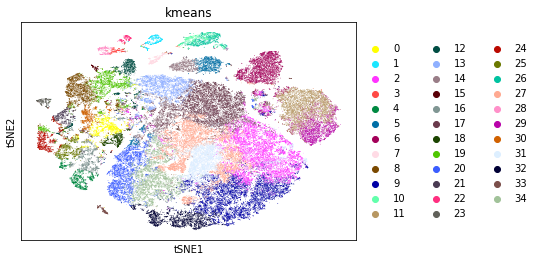

CPU times: user 1.47 s, sys: 166 ms, total: 1.64 s
Wall time: 1.52 s


In [22]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

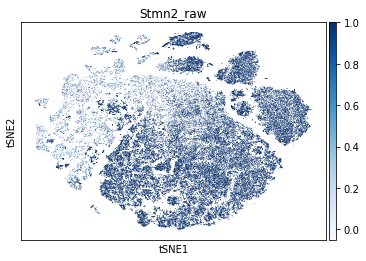

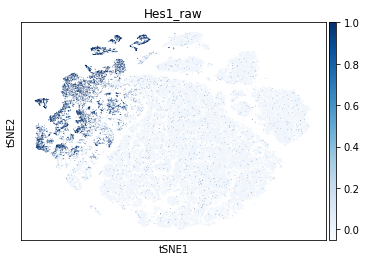

CPU times: user 1.36 s, sys: 205 ms, total: 1.57 s
Wall time: 1.11 s


In [23]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [24]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 1min 33s, sys: 52.9 s, total: 2min 26s
Wall time: 40.2 s


In [25]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 3min 6s, sys: 2min 23s, total: 5min 29s
Wall time: 11.6 s


In [27]:
#add pyhton-igraph sinc the next cell made error
!pip install python-igraph


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.7 MB/s eta 0:00:0000:0100:01
  Created wheel for python-igraph: filename=python_igraph-0.9.11-py3-none-any.whl size=9074 sha256=3ccdc80778da8801a934065ee695a0cf33c6c96a58df4530f90579e1a7a50cd6
  Stored in directory: /workspace/.cache/pip/wheels/80/cc/db/88e7da87ff0cc3d1f311760bdaea8d531c2b209ec19dfda13c
Successfully built python-igraph


In [29]:
!pip install louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:0000:010:01


In [30]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 56.6 s, sys: 518 ms, total: 57.2 s
Wall time: 56.8 s


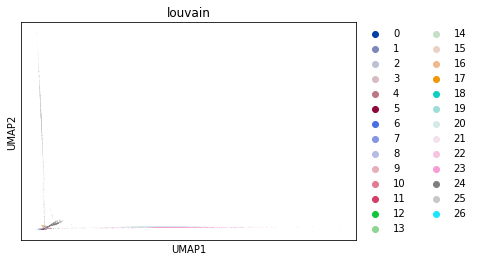

CPU times: user 2.9 s, sys: 2 s, total: 4.91 s
Wall time: 1.28 s


In [31]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [33]:
!pip3 install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:0000:010:01


In [34]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 54.7 s, sys: 992 ms, total: 55.7 s
Wall time: 55.6 s


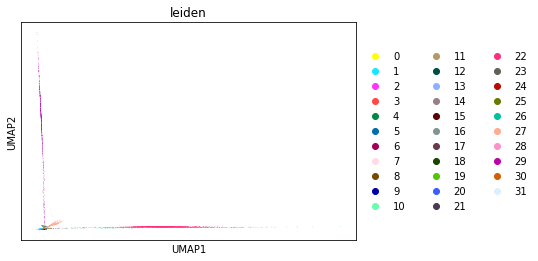

CPU times: user 2.94 s, sys: 2.04 s, total: 4.99 s
Wall time: 1.36 s


In [35]:
%%time
sc.pl.umap(adata, color=["leiden"])

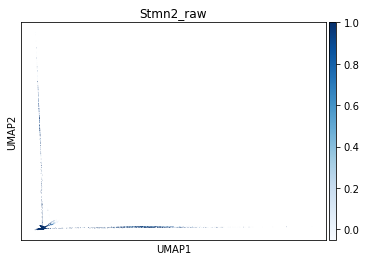

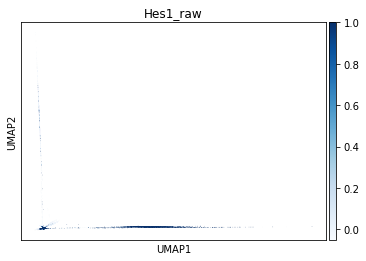

CPU times: user 1.27 s, sys: 251 ms, total: 1.52 s
Wall time: 1.05 s


In [36]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Differential expression analysis

In [37]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=50, groups='all', reference='rest', method='logreg')

CPU times: user 37min 5s, sys: 9min 57s, total: 47min 3s
Wall time: 1min 34s


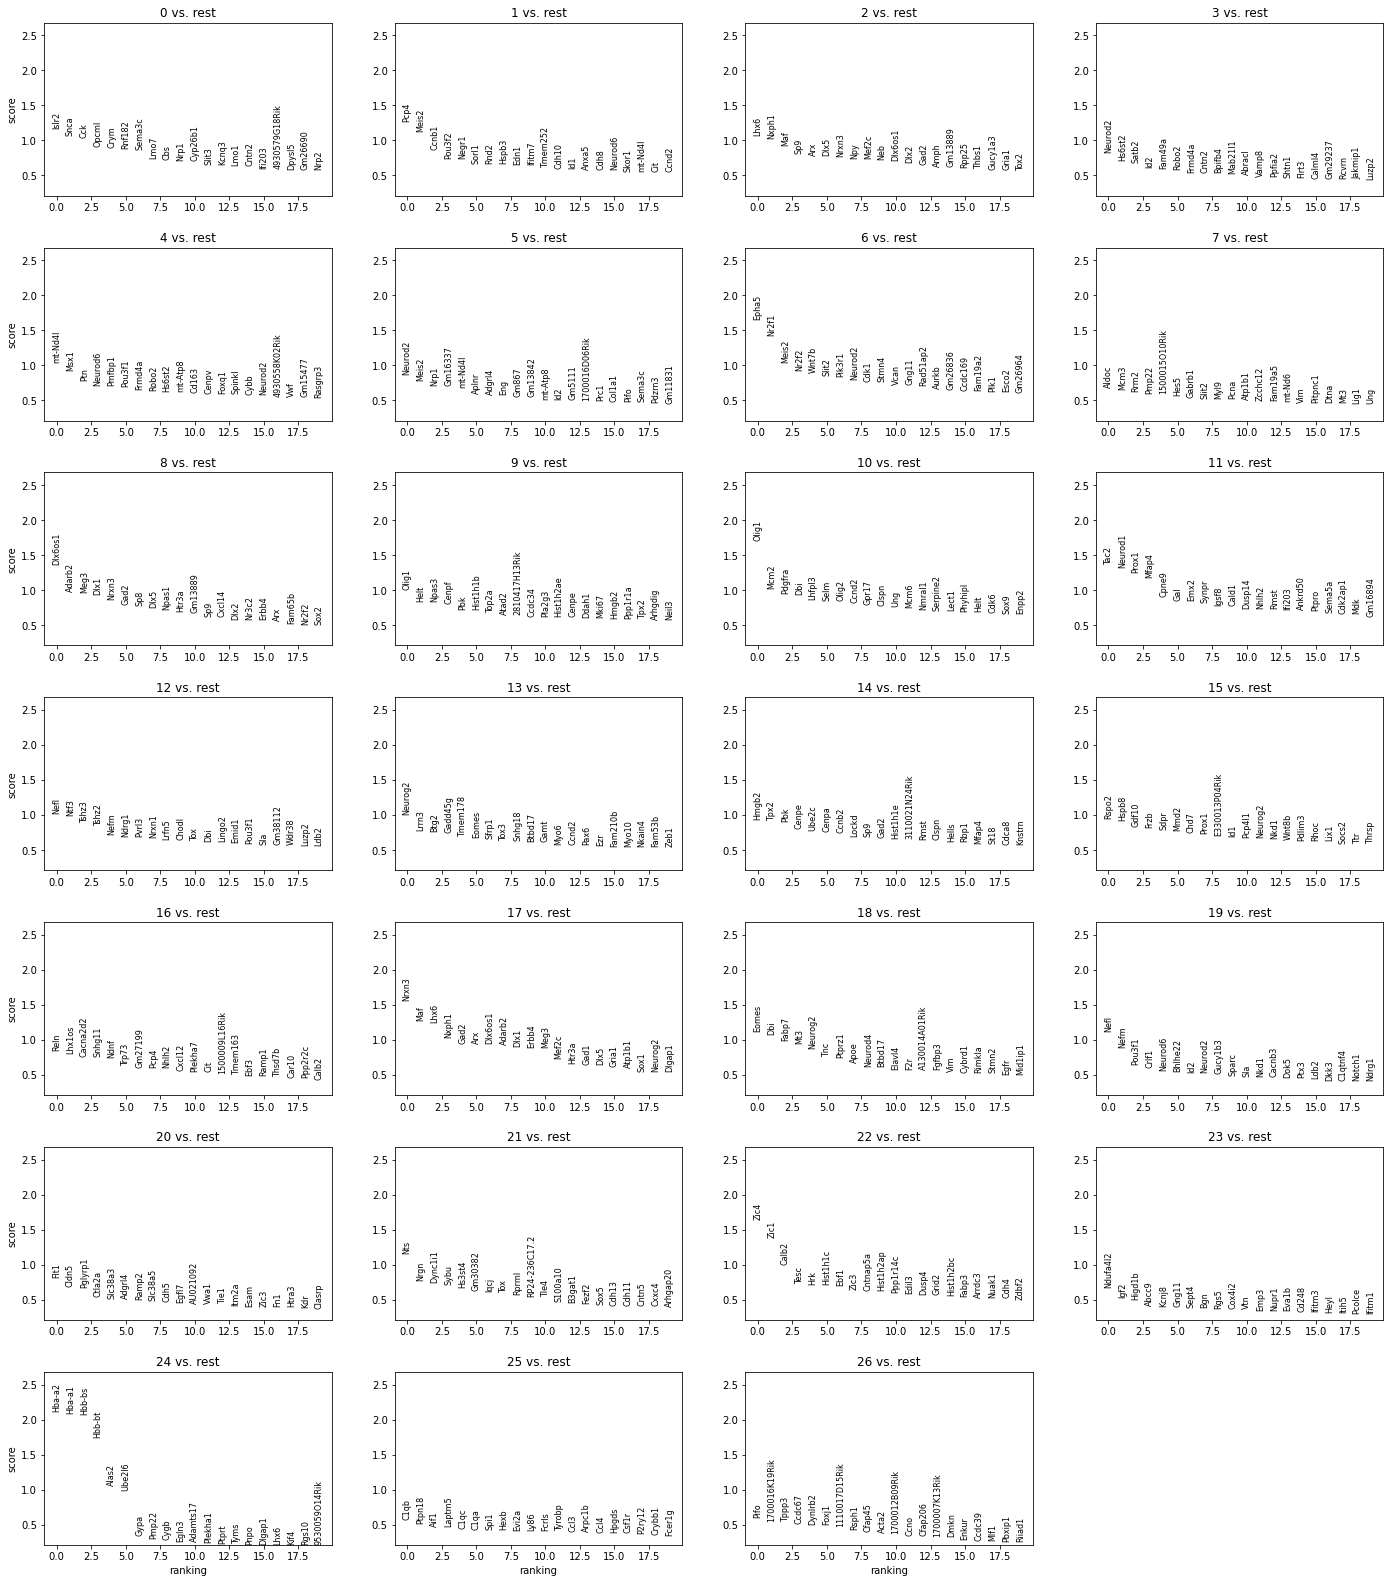

CPU times: user 4.12 s, sys: 300 ms, total: 4.42 s
Wall time: 4.18 s


In [38]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [39]:
reanalysis_start = time.time()

In [40]:
%%time
hes1_cells = adata.obs["Hes1_raw"] > 0.0
adata = adata[hes1_cells,:]
adata.shape

CPU times: user 9.96 ms, sys: 525 µs, total: 10.5 ms
Wall time: 9.32 ms


(12515, 4000)

We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

In [41]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 44.4 s, sys: 15.4 s, total: 59.8 s
Wall time: 6.51 s


And plot the results:

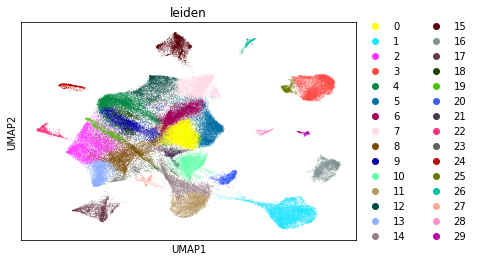

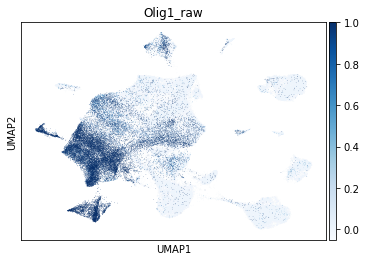

CPU times: user 1.75 s, sys: 321 ms, total: 2.07 s
Wall time: 1.58 s


In [35]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [36]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 217.67653822898865


In [37]:
print("Full time: %s" % (time.time() - start))

Full time: 17071.51189470291
